# Finetune EfficientNet


## efficientnet_224silence


With 224x224 silence-removed melspectrogram images without data augmentation


In [1]:
import sys
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
import numpy as np
import random

In [2]:
# Get the absolute path to the project root without relying on __file__
notebook_path = os.getcwd()  # Gets current working directory
project_root = os.path.abspath(os.path.join(notebook_path, "../../.."))
sys.path.insert(0, project_root)

In [3]:
print(torch.__version__)
print(torch.cuda.is_available())

2.5.1+cu121
True


Set the seed for reproducability


In [4]:
random_seed = 42

torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

if (torch.cuda.is_available()):
    torch.cuda.manual_seed(random_seed)

Set some constant strings


In [5]:
model_name = 'efficientnet_224silence'

train_csv = '../../../data/melspectrogram_train_dataset.csv'
test_csv = '../../../data/melspectrogram_test_dataset.csv'
val_csv = '../../../data/melspectrogram_val_dataset.csv'
root_dir = '../../../data/'
class_weights_path = '../../../data/class_weights.pt'

Import other helper classes


In [6]:
from cnn.datasets.MelspectrogramDataset import MelSpectrogramDataset
from cnn.pipeline.Pipeline import Pipeline

Define the model


In [7]:
model = models.efficientnet_b0(pretrained=True)

c:\Users\profi\OneDrive\Desktop\AI-Project--Speech-Emotion-Recognition\myenv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\profi\OneDrive\Desktop\AI-Project--Speech-Emotion-Recognition\myenv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Prepare for fine-tuning


In [8]:
# Number of classes
num_classes = 9

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Modify final fully connected layer according to number of classes
num_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_features, num_classes)

# Unfreeze the last 3 layers so that they can be fine-tuned
# Adjust the indices based on the actual number of layers in model.features
for idx in [-3, -2, -1]:  # Use negative indices to target the last 3 layers
    for param in model.features[idx].parameters():
        param.requires_grad = True

# Replace classifier
num_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_features, num_classes)

# Unfreeze classifier
for param in model.classifier.parameters():
    param.requires_grad = True

# Move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

Define the learning rate, criterion, optimizer, transformations, and number of epochs


In [9]:
learning_rate = 0.001

class_weights = torch.load(class_weights_path).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),          # Convert to Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[
                         0.229, 0.224, 0.225])  # Normalize to ImageNet stats
])

num_epochs = 50

C:\Users\profi\AppData\Local\Temp\ipykernel_27676\3408896021.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  class_weights = torch.load(class_weights_path).to(device)


Prepare datasets and dataloaders


In [10]:
trainset = MelSpectrogramDataset(
    csv_file=train_csv, root_dir=root_dir, transform=transform)
valset = MelSpectrogramDataset(
    csv_file=val_csv, root_dir=root_dir, transform=transform)
testset = MelSpectrogramDataset(
    csv_file=test_csv, root_dir=root_dir, transform=transform)

trainloader = DataLoader(trainset, batch_size=128,
                         shuffle=True, num_workers=8, pin_memory=True)
valloader = DataLoader(valset, batch_size=128,
                       shuffle=False, num_workers=8, pin_memory=True)
testloader = DataLoader(testset, batch_size=128,
                        shuffle=False, num_workers=8, pin_memory=True)

Execute the pipeline


Mapping from Emotion to Number: {'Anger': 0, 'Bored': 1, 'Disgust': 2, 'Fear': 3, 'Happy': 4, 'Neutral': 5, 'Question': 6, 'Sad': 7, 'Surprise': 8}
Model is on: cuda:0
Epoch 1/50


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.77it/s, Loss=0.24020995199680328, Elapsed=20.0216s, ETA=0.0000s]


Epoch 1 completed in 63.8037s
Train Loss: 0.9511689190575153 - Train Accuracy: 59.22977770742407
Validation Loss: 0.7609689396619796 - Validation Accuracy: 68.3938370620515

Epoch 2/50


Validating: 100%|██████████| 75/75 [00:05<00:00, 13.77it/s, Loss=0.07272898405790329, Elapsed=15.8073s, ETA=0.0000s] 


Epoch 2 completed in 54.5199s
Train Loss: 0.707171771567681 - Train Accuracy: 69.67730263901765
Validation Loss: 0.694065260787805 - Validation Accuracy: 70.46222034613761

Epoch 3/50


Validating: 100%|██████████| 75/75 [00:05<00:00, 13.84it/s, Loss=0.37045562267303467, Elapsed=15.7951s, ETA=0.0000s] 


Epoch 3 completed in 54.0847s
Train Loss: 0.5942721670073581 - Train Accuracy: 74.60708713054883
Validation Loss: 0.6469407014052073 - Validation Accuracy: 73.14267623469819

Epoch 4/50


Validating: 100%|██████████| 75/75 [00:05<00:00, 13.78it/s, Loss=0.134170800447464, Elapsed=15.8149s, ETA=0.0000s]   


Epoch 4 completed in 54.0533s
Train Loss: 0.5085827003669188 - Train Accuracy: 78.44463037923158
Validation Loss: 0.7094134942690531 - Validation Accuracy: 73.18488813845504

EarlyStopping counter: 1/5
Epoch 5/50


Validating: 100%|██████████| 75/75 [00:05<00:00, 13.77it/s, Loss=0.17290744185447693, Elapsed=15.8399s, ETA=0.0000s]


Epoch 5 completed in 54.2636s
Train Loss: 0.43469834586099393 - Train Accuracy: 81.10173899278624
Validation Loss: 0.6935346722602844 - Validation Accuracy: 73.60700717602364

EarlyStopping counter: 2/5
Epoch 6/50


Validating: 100%|██████████| 75/75 [00:05<00:00, 13.82it/s, Loss=0.1081189438700676, Elapsed=15.7682s, ETA=0.0000s]  


Epoch 6 completed in 54.1206s
Train Loss: 0.376877346350623 - Train Accuracy: 83.27039189525338
Validation Loss: 0.7646768886844317 - Validation Accuracy: 77.11059518784296

EarlyStopping counter: 3/5
Epoch 7/50


Validating: 100%|██████████| 75/75 [00:05<00:00, 13.95it/s, Loss=0.07016546279191971, Elapsed=15.7025s, ETA=0.0000s]


Epoch 7 completed in 54.0829s
Train Loss: 0.3131546490971064 - Train Accuracy: 86.1219782456299
Validation Loss: 0.8031189851959546 - Validation Accuracy: 75.62262558041367

EarlyStopping counter: 4/5
Epoch 8/50


Validating: 100%|██████████| 75/75 [00:05<00:00, 13.87it/s, Loss=0.5433414578437805, Elapsed=15.6762s, ETA=0.0000s] 

Epoch 8 completed in 54.0150s
Train Loss: 0.2662833970406152 - Train Accuracy: 87.90619841251895
Validation Loss: 0.8132621002197266 - Validation Accuracy: 75.13718868720979

EarlyStopping counter: 5/5
🔁 Early stopping triggered!


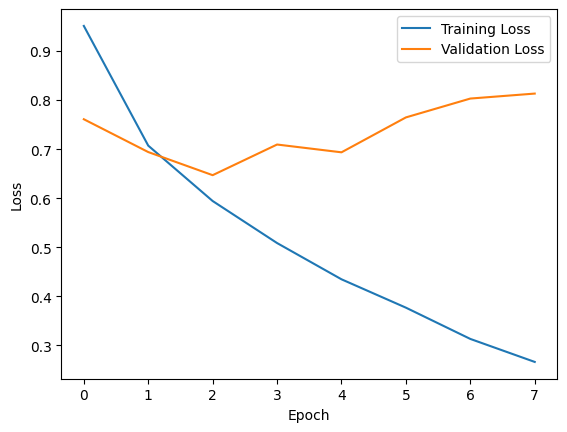

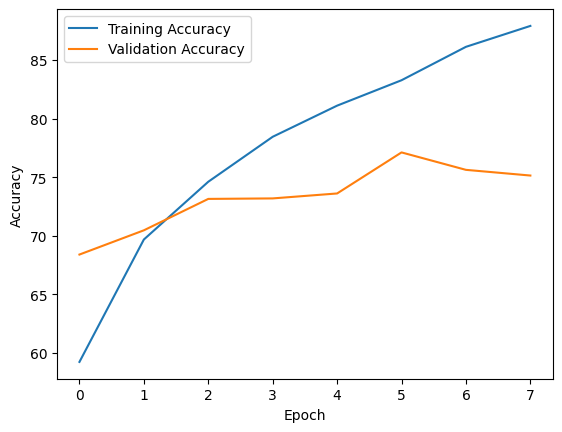

c:\Users\profi\OneDrive\Desktop\AI-Project--Speech-Emotion-Recognition\cnn\pipeline\Pipeline.py:217: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torc

Evaluating best model on test set...


Testing: 100%|██████████| 75/75 [00:17<00:00,  4.21it/s]

Test Accuracy: 0.7666
Test Precision: 0.7722
Test Recall: 0.7666
Test F1-score: 0.7671

              precision    recall  f1-score   support

       Anger       0.78      0.79      0.78       916
       Bored       0.80      0.90      0.85      1098
     Disgust       0.50      0.67      0.57       291
        Fear       0.53      0.60      0.57       308
       Happy       0.82      0.70      0.76      1914
     Neutral       0.71      0.73      0.72      2226
    Question       0.87      0.90      0.89      1139
         Sad       0.82      0.69      0.75       857
    Surprise       0.79      0.77      0.78       728

    accuracy                           0.77      9477
   macro avg       0.74      0.75      0.74      9477
weighted avg       0.77      0.77      0.77      9477



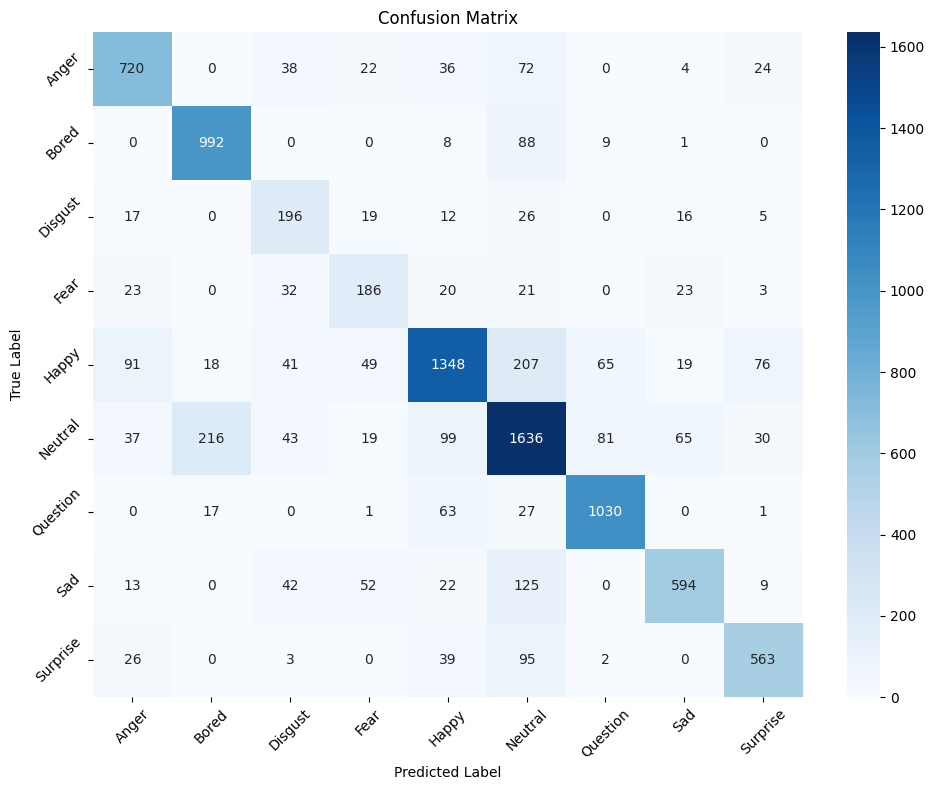

In [11]:
Pipeline.execute(
    model=model,
    labelmap=trainset.label_map,
    trainloader=trainloader,
    valloader=valloader,
    testloader=testloader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    num_epochs=num_epochs,
    model_name=model_name,
    patience=5
)